### Importing the required Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
import lightgbm as lgb
from mlxtend.regressor import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.linear_model import Lasso

In [2]:
import pickle

In [20]:
df = pd.read_csv('preprocessed.csv', dtype={'fullVisitorId': str})

In [21]:
df.columns

Index(['Unnamed: 0', 'channelGrouping', 'date', 'fullVisitorId', 'visitNumber',
       'visitStartTime', 'device.browser', 'device.operatingSystem',
       'device.isMobile', 'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region',
       'geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain',
       'totals.hits', 'totals.pageviews', 'totals.bounces', 'totals.newVisits',
       'totals.transactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
       'trafficSource.isTrueDirect', 'trafficSource.referralPath'],
      dtype='object')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Unnamed: 0                  903653 non-null  int64  
 1   channelGrouping             903653 non-null  object 
 2   date                        903653 non-null  object 
 3   fullVisitorId               903653 non-null  object 
 4   visitNumber                 903653 non-null  int64  
 5   visitStartTime              903653 non-null  int64  
 6   device.browser              903653 non-null  object 
 7   device.operatingSystem      903653 non-null  object 
 8   device.isMobile             903653 non-null  bool   
 9   device.deviceCategory       903653 non-null  object 
 10  geoNetwork.continent        903653 non-null  object 
 11  geoNetwork.subContinent     903653 non-null  object 
 12  geoNetwork.country          903653 non-null  object 
 13  geoNetwork.reg

In [23]:
df['totals.transactionRevenue'].fillna(0,inplace=True)

### Doing time based split of data

In [24]:
df['date'] = pd.to_datetime(df["date"], infer_datetime_format=True, format="%Y%m%d")
df = df.sort_values('date')

In [25]:
train_data, test_data= np.split(df, [int(.85 *len(df))])

### Preparing the Train and Test Data

#### The Null Values Count

In [26]:
dt=(train_data.isnull().sum()/len(train_data.index))*100
missing_values=pd.DataFrame({'Columns':dt.index,'Null Values Count':dt.values})
missing_values

,Columns,Null Values Count
0,Unnamed: 0,0.000000
1,channelGrouping,0.000000
2,date,0.000000
3,fullVisitorId,0.000000
4,visitNumber,0.000000
5,visitStartTime,0.000000
6,device.browser,0.000000
7,device.operatingSystem,0.000000
8,device.isMobile,0.000000
9,device.deviceCategory,0.000000


#### Featurizing Date and Time

In [27]:
train_data['weekday'] = train_data.date.dt.weekday
test_data['weekday'] = test_data.date.dt.weekday

train_data['day'] = train_data.date.dt.day
test_data['day'] = test_data.date.dt.day

train_data['month'] = train_data.date.dt.month
test_data['month'] = test_data.date.dt.month

train_data['year' ] =train_data.date.dt.year
test_data['year'] = test_data.date.dt.year

In [28]:
def process_time(posix_time):
    return datetime.utcfromtimestamp(posix_time).strftime('%Y-%m-%d %H:%M:%S')
def process_hour(time):
    return str(time)[-8:-6]

In [29]:
train_data['visitStartTime'] = train_data['visitStartTime'].apply(process_time)
test_data['visitStartTime'] = test_data['visitStartTime'].apply(process_time)

train_data['visitHour'] = train_data['visitStartTime'].apply(process_hour)
test_data['visitHour'] = test_data['visitStartTime'].apply(process_hour)

In [30]:
categorical_columns=['channelGrouping','device.browser','device.operatingSystem','device.isMobile','device.deviceCategory','geoNetwork.continent','geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region','geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain','totals.bounces','totals.newVisits','trafficSource.campaign','trafficSource.source','trafficSource.medium', 'trafficSource.keyword','trafficSource.isTrueDirect','trafficSource.referralPath','weekday','day','month','year','visitHour']

#### Target Encoding all The Categorical Features
* The Target Encoder imputes all the missing values with Median Values 

In [71]:
encoder=ce.TargetEncoder(cols=categorical_columns, handle_missing='median') 
encoder.fit( X = train_data[categorical_columns],y = train_data['totals.transactionRevenue'] )
train_data[categorical_columns] = encoder.transform( train_data[categorical_columns], train_data['totals.transactionRevenue'] )

In [72]:
filehandler = open("encoder.obj","wb")
pickle.dump(encoder,filehandler)
filehandler.close()

In [13]:
test_data[categorical_columns] = encoder.transform( test_data[categorical_columns] )

#### PageViews feature had missing values, so I imputed totals.pageviews values with Median (Median is immune outliers)

In [14]:
train_data['totals.pageviews'].fillna(np.nanmedian(train_data['totals.pageviews']),inplace=True)

In [15]:
test_data['totals.pageviews'].fillna(np.nanmedian(train_data['totals.pageviews']),inplace=True)

In [16]:
dt = (test_data.isnull().sum()/len(test_data.index))*100
missing_values = pd.DataFrame({'Columns':dt.index,'Null Values Count':dt.values})
missing_values

,Columns,Null Values Count
0,Unnamed: 0,0.0
1,channelGrouping,0.0
2,date,0.0
3,fullVisitorId,0.0
4,visitNumber,0.0
5,visitStartTime,0.0
6,device.browser,0.0
7,device.operatingSystem,0.0
8,device.isMobile,0.0
9,device.deviceCategory,0.0


#### In the given dataset, each row represents a visit of the customer. Since this is a data of whole year, a Customer would have made multiple visits to the store during this period, and hence there can be multiple records of a sinlge customer.

#### Grouping all train the data with respect to Visitor ID, such that each visitor has only one row in the dataset

In [17]:
grouped_train_df = train_data.groupby('fullVisitorId').agg({ 'totals.pageviews':[('total_pageviews_max',lambda x : x.dropna().max()),
                                                                   ('total_pageviews_min',lambda x : x.dropna().min()), 
                                                                   ('total_pageviews_mean',lambda x : x.dropna().mean()),
                                                                   ('total_pageviews_mode',lambda x : x.value_counts().index[0])],
                                           
                                     'channelGrouping': [('channelGrouping_max',lambda x : x.dropna().max()),
                                                         ('channelGrouping_min',lambda x : x.dropna().min()),
                                                         ('channelGrouping_mode',lambda x : x.value_counts().index[0])],
                                           
                                     'visitNumber': [('visitNumber_max',lambda x : x.dropna().max()),
                                                     ('visitNumber_mean',lambda x : x.dropna().mean()),
                                                     ('visitNumber_min',lambda x : x.dropna().min())],
                                           
                                     'device.browser':[('device_browser_max',lambda x : x.dropna().max()),
                                                       ('device_browser_min',lambda x : x.dropna().min()),
                                                       ('device_browser_mode',lambda x : x.value_counts().index[0])],
                                           
                                    'device.operatingSystem':[('device_operatingSystem_max',lambda x : x.dropna().max()),
                                                              ('device_operatingSystem_min',lambda x : x.dropna().min()),
                                                              ('device_operatingSystem_mode',lambda x : x.value_counts().index[0])],
                                   
                                     'device.isMobile':[('device_isMobile_max',lambda x : x.dropna().max()),
                                                        ('device_isMobile_min',lambda x : x.dropna().min())],
                                           
                                   'device.deviceCategory':[('device_deviceCategory_max',lambda x : x.dropna().max()),
                                                            ('device_deviceCategory_min',lambda x : x.dropna().min()),
                                                            ('device_deviceCategory_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'geoNetwork.continent':[('geoNetwork_continent_max',lambda x : x.dropna().max()),
                                                           ('geoNetwork_continent_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.subContinent':[('geoNetwork_subContinent_max',lambda x : x.dropna().max()),
                                                              ('geoNetwork_subContinent_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.country':[('geoNetwork_country_max',lambda x : x.dropna().max()),
                                                         ('geoNetwork_country_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.region':[('geoNetwork_region_max',lambda x : x.dropna().max()),
                                                        ('geoNetwork_region_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.metro':[('geoNetwork_metro_max',lambda x : x.dropna().max()),
                                                       ('geoNetwork_metro_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.city':[('geoNetwork_city_max',lambda x : x.dropna().max()),
                                                      ('geoNetwork_city_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.networkDomain':[('geoNetwork_networkDomain_max',lambda x : x.dropna().max()),
                                                               ('geoNetwork_networkDomain_min',lambda x : x.dropna().min()),
                                                               ('geoNetwork_networkDomain_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'totals.hits':[('totals_hits_max',lambda x : x.dropna().max()),
                                                  ('totals_hits_min',lambda x : x.dropna().min()),
                                                  ('totals_hits_mean',lambda x : x.dropna().mean())],
                                           
                                   'totals.bounces':[('totals_bounces_max',lambda x : x.dropna().max()),
                                                     ('totals_bounces_min',lambda x : x.dropna().min()),
                                                     ('totals_bounces_mean',lambda x : x.dropna().mean())],
                                           
                                   'totals.newVisits':[('totals_newVisits_max',lambda x : x.dropna().max()),
                                                       ('totals_newVisits_min',lambda x : x.dropna().min())],
                                           
                                   'trafficSource.campaign':[('trafficSource_campaign_max',lambda x : x.dropna().max()),
                                                             ('trafficSource_campaign_min',lambda x : x.dropna().min()),
                                                             ('trafficSource_campaign_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'trafficSource.source':[('trafficSource_source_max',lambda x : x.dropna().max()),
                                                           ('trafficSource_source_min',lambda x : x.dropna().min()),
                                                           ('trafficSource_source_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'trafficSource.medium':[('trafficSource_medium_max',lambda x : x.dropna().max()),
                                                           ('trafficSource_medium_min',lambda x : x.dropna().min()),
                                                           ('trafficSource_medium_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'trafficSource.keyword':[('trafficSource_keyword_max',lambda x : x.dropna().max()),
                                                            ('trafficSource_keyword_min',lambda x : x.dropna().min())],
                                           
                                   'trafficSource.isTrueDirect':[('trafficSource_isTrueDirect_max',lambda x : x.dropna().max()),
                                                                 ('trafficSource_isTrueDirect_min',lambda x : x.dropna().min()),
                                                                 ('trafficSource_isTrueDirect_mean',lambda x : x.dropna().mean())],
                                           
                                   'trafficSource.referralPath':[('trafficSource_referralPath_max',lambda x : x.dropna().max()),
                                                                 ('trafficSource_referralPath_min',lambda x : x.dropna().min()),
                                                                 ('trafficSource_referralPath_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'weekday':[('weekday_max',lambda x : x.dropna().max()),
                                              ('weekday_min',lambda x : x.dropna().min()),
                                              ('weekday_mean',lambda x : x.dropna().mean()),
                                              ('weekday_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'day':[('day_max',lambda x : x.dropna().max()),
                                          ('day_min',lambda x : x.dropna().min()),
                                          ('day_mean',lambda x : x.dropna().mean()),
                                          ('day_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'month':[('month_max',lambda x : x.dropna().max()),
                                            ('month_min',lambda x : x.dropna().min()),
                                            ('month_mean',lambda x : x.dropna().mean()),
                                            ('month_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'year':[('year_max',lambda x : x.dropna().max()),
                                           ('year_min',lambda x : x.dropna().min()),
                                           ('year_mode',lambda x : x.value_counts().index[0])], 
                                           
                                   'visitHour':[('visitHour_max',lambda x : x.dropna().max()),
                                                ('visitHour_mean',lambda x : x.dropna().mean()),
                                                ('visitHour_min',lambda x : x.dropna().min()),
                                                ('visitHour_mode',lambda x : x.value_counts().index[0])], 
                                           
                                'totals.transactionRevenue':[('revenue_sum',lambda x : x.dropna().sum())]
                                                   
                                   
                                  })

In [18]:
grouped_train_df.head(2)

totals.pageviews                      \
                    total_pageviews_max total_pageviews_min   
fullVisitorId                                                 
0000010278554503158                 2.0                 2.0   
0000020424342248747                 3.0                 3.0   

                                                               \
                    total_pageviews_mean total_pageviews_mode   
fullVisitorId                                                   
0000010278554503158                  2.0                  2.0   
0000020424342248747                  3.0                  3.0   

                        channelGrouping                      \
                    channelGrouping_max channelGrouping_min   
fullVisitorId                                                 
0000010278554503158        1.557128e+06        1.557128e+06   
0000020424342248747        1.557128e+06        1.557128e+06   

                                             visitNumber                   \
                    channelGrouping_mode visitNumber_max visitNumber_mean   
fullVisitorId                                                               
0000010278554503158         1.557128e+06               1              1.0   
0000020424342248747         1.557128e+06               1              1.0   

                                     ...         month                \
                    visitNumber_min  ...    month_mean    month_mode   
fullVisitorId                        ...                               
0000010278554503158               1  ...  1.686201e+06  1.686201e+06   
0000020424342248747               1  ...  1.713245e+06  1.713245e+06   

                             year                                 visitHour  \
                         year_max      year_min     year_mode visitHour_max   
fullVisitorId                                                                 
0000010278554503158  1.733695e+06  1.733695e+06  1.733695e+06  1.697293e+06   
0000020424342248747  1.733695e+06  1.733695e+06  1.733695e+06  1.513431e+06   

                                                                 \
                    visitHour_mean visitHour_min visitHour_mode   
fullVisitorId                                                     
0000010278554503158   1.697293e+06  1.697293e+06   1.697293e+06   
0000020424342248747   1.513431e+06  1.513431e+06   1.513431e+06   

                    totals.transactionRevenue  
                                  revenue_sum  
fullVisitorId                                  
0000010278554503158                       0.0  
0000020424342248747                       0.0  

[2 rows x 81 columns]

In [19]:
grouped_train_df.columns = grouped_train_df.columns.droplevel()

In [20]:
grouped_train_df.head(2)

,total_pageviews_max,total_pageviews_min,total_pageviews_mean,total_pageviews_mode,channelGrouping_max,channelGrouping_min,channelGrouping_mode,visitNumber_max,visitNumber_mean,visitNumber_min,...,month_mean,month_mode,year_max,year_min,year_mode,visitHour_max,visitHour_mean,visitHour_min,visitHour_mode,revenue_sum
fullVisitorId,,,,,,,,,,,,,,,,,,,,,
0000010278554503158,2.0,2.0,2.0,2.0,1.557128e+06,1.557128e+06,1.557128e+06,1,1.0,1,...,1.686201e+06,1.686201e+06,1.733695e+06,1.733695e+06,1.733695e+06,1.697293e+06,1.697293e+06,1.697293e+06,1.697293e+06,0.0
0000020424342248747,3.0,3.0,3.0,3.0,1.557128e+06,1.557128e+06,1.557128e+06,1,1.0,1,...,1.713245e+06,1.713245e+06,1.733695e+06,1.733695e+06,1.733695e+06,1.513431e+06,1.513431e+06,1.513431e+06,1.513431e+06,0.0


In [21]:
grouped_train_df = grouped_train_df.reset_index()

In [22]:
grouped_train_df.head(2)

,fullVisitorId,total_pageviews_max,total_pageviews_min,total_pageviews_mean,total_pageviews_mode,channelGrouping_max,channelGrouping_min,channelGrouping_mode,visitNumber_max,visitNumber_mean,...,month_mean,month_mode,year_max,year_min,year_mode,visitHour_max,visitHour_mean,visitHour_min,visitHour_mode,revenue_sum
0,0000010278554503158,2.0,2.0,2.0,2.0,1.557128e+06,1.557128e+06,1.557128e+06,1,1.0,...,1.686201e+06,1.686201e+06,1.733695e+06,1.733695e+06,1.733695e+06,1.697293e+06,1.697293e+06,1.697293e+06,1.697293e+06,0.0
1,0000020424342248747,3.0,3.0,3.0,3.0,1.557128e+06,1.557128e+06,1.557128e+06,1,1.0,...,1.713245e+06,1.713245e+06,1.733695e+06,1.733695e+06,1.733695e+06,1.513431e+06,1.513431e+06,1.513431e+06,1.513431e+06,0.0


In [23]:
grouped_train_df['log_Revenue'] = np.log1p(grouped_train_df['revenue_sum'])

In [30]:
grouped_train_df.drop('revenue_sum', axis=1, inplace = True)

In [31]:
### Ensuring the dataset has no Missing Values
dt=(grouped_train_df.isnull().sum()/len(grouped_train_df.index))*100
missing_values=pd.DataFrame({'Columns':dt.index,'Null Values Count':dt.values})
missing_values[missing_values['Null Values Count']>0]

,Columns,Null Values Count


In [221]:
grouped_train_df.to_csv('grouped_train_df.csv')

In [2]:
grouped_train_df = pd.read_csv('grouped_train_df.csv',dtype={'fullVisitorId': str})

#### Following the same steps for Test Data

In [33]:
grouped_test_df = test_data.groupby('fullVisitorId').agg({ 'totals.pageviews':[('total_pageviews_max',lambda x : x.dropna().max()),
                                                                   ('total_pageviews_min',lambda x : x.dropna().min()), 
                                                                   ('total_pageviews_mean',lambda x : x.dropna().mean()),
                                                                   ('total_pageviews_mode',lambda x : x.value_counts().index[0])],
                                           
                                     'channelGrouping': [('channelGrouping_max',lambda x : x.dropna().max()),
                                                         ('channelGrouping_min',lambda x : x.dropna().min()),
                                                         ('channelGrouping_mode',lambda x : x.value_counts().index[0])],
                                           
                                     'visitNumber': [('visitNumber_max',lambda x : x.dropna().max()),
                                                     ('visitNumber_mean',lambda x : x.dropna().mean()),
                                                     ('visitNumber_min',lambda x : x.dropna().min())],
                                           
                                     'device.browser':[('device_browser_max',lambda x : x.dropna().max()),
                                                       ('device_browser_min',lambda x : x.dropna().min()),
                                                       ('device_browser_mode',lambda x : x.value_counts().index[0])],
                                           
                                    'device.operatingSystem':[('device_operatingSystem_max',lambda x : x.dropna().max()),
                                                              ('device_operatingSystem_min',lambda x : x.dropna().min()),
                                                              ('device_operatingSystem_mode',lambda x : x.value_counts().index[0])],
                                   
                                     'device.isMobile':[('device_isMobile_max',lambda x : x.dropna().max()),
                                                        ('device_isMobile_min',lambda x : x.dropna().min())],
                                           
                                   'device.deviceCategory':[('device_deviceCategory_max',lambda x : x.dropna().max()),
                                                            ('device_deviceCategory_min',lambda x : x.dropna().min()),
                                                            ('device_deviceCategory_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'geoNetwork.continent':[('geoNetwork_continent_max',lambda x : x.dropna().max()),
                                                           ('geoNetwork_continent_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.subContinent':[('geoNetwork_subContinent_max',lambda x : x.dropna().max()),
                                                              ('geoNetwork_subContinent_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.country':[('geoNetwork_country_max',lambda x : x.dropna().max()),
                                                         ('geoNetwork_country_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.region':[('geoNetwork_region_max',lambda x : x.dropna().max()),
                                                        ('geoNetwork_region_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.metro':[('geoNetwork_metro_max',lambda x : x.dropna().max()),
                                                       ('geoNetwork_metro_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.city':[('geoNetwork_city_max',lambda x : x.dropna().max()),
                                                      ('geoNetwork_city_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.networkDomain':[('geoNetwork_networkDomain_max',lambda x : x.dropna().max()),
                                                               ('geoNetwork_networkDomain_min',lambda x : x.dropna().min()),
                                                               ('geoNetwork_networkDomain_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'totals.hits':[('totals_hits_max',lambda x : x.dropna().max()),
                                                  ('totals_hits_min',lambda x : x.dropna().min()),
                                                  ('totals_hits_mean',lambda x : x.dropna().mean())],
                                           
                                   'totals.bounces':[('totals_bounces_max',lambda x : x.dropna().max()),
                                                     ('totals_bounces_min',lambda x : x.dropna().min()),
                                                     ('totals_bounces_mean',lambda x : x.dropna().mean())],
                                           
                                   'totals.newVisits':[('totals_newVisits_max',lambda x : x.dropna().max()),
                                                       ('totals_newVisits_min',lambda x : x.dropna().min())],
                                           
                                   'trafficSource.campaign':[('trafficSource_campaign_max',lambda x : x.dropna().max()),
                                                             ('trafficSource_campaign_min',lambda x : x.dropna().min()),
                                                             ('trafficSource_campaign_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'trafficSource.source':[('trafficSource_source_max',lambda x : x.dropna().max()),
                                                           ('trafficSource_source_min',lambda x : x.dropna().min()),
                                                           ('trafficSource_source_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'trafficSource.medium':[('trafficSource_medium_max',lambda x : x.dropna().max()),
                                                           ('trafficSource_medium_min',lambda x : x.dropna().min()),
                                                           ('trafficSource_medium_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'trafficSource.keyword':[('trafficSource_keyword_max',lambda x : x.dropna().max()),
                                                            ('trafficSource_keyword_min',lambda x : x.dropna().min())],
                                           
                                   'trafficSource.isTrueDirect':[('trafficSource_isTrueDirect_max',lambda x : x.dropna().max()),
                                                                 ('trafficSource_isTrueDirect_min',lambda x : x.dropna().min()),
                                                                 ('trafficSource_isTrueDirect_mean',lambda x : x.dropna().mean())],
                                           
                                   'trafficSource.referralPath':[('trafficSource_referralPath_max',lambda x : x.dropna().max()),
                                                                 ('trafficSource_referralPath_min',lambda x : x.dropna().min()),
                                                                 ('trafficSource_referralPath_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'weekday':[('weekday_max',lambda x : x.dropna().max()),
                                              ('weekday_min',lambda x : x.dropna().min()),
                                              ('weekday_mean',lambda x : x.dropna().mean()),
                                              ('weekday_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'day':[('day_max',lambda x : x.dropna().max()),
                                          ('day_min',lambda x : x.dropna().min()),
                                          ('day_mean',lambda x : x.dropna().mean()),
                                          ('day_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'month':[('month_max',lambda x : x.dropna().max()),
                                            ('month_min',lambda x : x.dropna().min()),
                                            ('month_mean',lambda x : x.dropna().mean()),
                                            ('month_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'year':[('year_max',lambda x : x.dropna().max()),
                                           ('year_min',lambda x : x.dropna().min()),
                                           ('year_mode',lambda x : x.value_counts().index[0])], 
                                           
                                   'visitHour':[('visitHour_max',lambda x : x.dropna().max()),
                                                ('visitHour_mean',lambda x : x.dropna().mean()),
                                                ('visitHour_min',lambda x : x.dropna().min()),
                                                ('visitHour_mode',lambda x : x.value_counts().index[0])], 
                                           
                                'totals.transactionRevenue':[('revenue_sum',lambda x : x.dropna().sum())]
                                                   
                                   
                                  })

In [34]:
grouped_test_df.columns = grouped_test_df.columns.droplevel()
grouped_test_df = grouped_test_df.reset_index()
grouped_test_df['log_Revenue'] = np.log1p(grouped_test_df['revenue_sum'])
grouped_test_df.drop('revenue_sum', axis=1, inplace = True)

In [400]:
grouped_test_df.to_csv('grouped_test_df.csv')

In [3]:
grouped_test_df = pd.read_csv('grouped_test_df.csv',dtype={'fullVisitorId': str})

In [4]:
grouped_train_df.drop('Unnamed: 0',axis=1,inplace = True)

In [5]:
grouped_test_df.drop('Unnamed: 0',axis=1,inplace = True)

# Training Model 

## LGBM

In [44]:
GridParams =  {
    'learning_rate': [0.0001,0.001,0.01,0.1,1],   #Learning rate
    'n_estimators': [30,40,60,100,200,350,400],          #number of boosting iterations   
    'num_leaves': [6,8,12,15,16,20,25,50,100,120,150],          #number of leaves in full tree
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],          #Regression model to predict transaction amount
    'metric' : ['rmse'],                   #Performance metric as "RMSE
    'colsample_bytree' : [0.6, 0.8, 1],    #LightGBM will select 80% of features before training each tree, feature_fraction
    'subsample' : [0.7,0.8,0.9, 1],            #this will randomly select part of data without resampling, bagging_fraction
    'reg_alpha' : [0,0.5,0.8,1],                   #L1 regularization
    'reg_lambda' : [0,0.5,0.8,1],                  #L2 regularization
    'min_child_samples' : [1,10,20,30]           #Minimum number of data points needed in a child (leaf) node.   
    }

In [45]:
model_lgbm = lgb.LGBMRegressor()

#### Hyper Parameter Tuning using Random Search

In [31]:
#from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(model_lgbm,GridParams,cv=3, scoring = "neg_root_mean_squared_error")
%time random_search.fit(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1), grouped_train_df['log_Revenue'])

Wall time: 6min 54s


RandomizedSearchCV(cv=3, estimator=LGBMRegressor(),
                   param_distributions={'boosting_type': ['gbdt'],
                                        'colsample_bytree': [0.6, 0.8, 1],
                                        'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1],
                                        'metric': ['rmse'],
                                        'min_child_samples': [1, 10, 20],
                                        'n_estimators': [30, 40, 60, 100, 200,
                                                         350, 400],
                                        'num_leaves': [6, 8, 12, 15, 16, 20, 25,
                                                       50, 100, 120, 150],
                                        'objective': ['regression'],
                                        'reg_alpha': [0, 0.5, 0.8, 1],
                                        'reg_lambda': [0, 0.5, 0.8, 1],
           

#### Best Hyper parameters

In [32]:
results=pd.DataFrame(random_search.cv_results_)
results.sort_values(by='rank_test_score',inplace=True)
results.params.values[0]

{'subsample': 0.7,
 'reg_lambda': 1,
 'reg_alpha': 0.5,
 'objective': 'regression',
 'num_leaves': 100,
 'n_estimators': 350,
 'min_child_samples': 1,
 'metric': 'rmse',
 'learning_rate': 0.1,
 'colsample_bytree': 0.8,
 'boosting_type': 'gbdt'}

In [13]:
lgbm = lgb.LGBMRegressor(subsample= 0.7, reg_lambda =1, reg_alpha= 0.5 ,objective='regression', num_leaves=100, n_estimators = 350, min_child_samples= 1,metric='rmse',learning_rate= 0.1,colsample_bytree= 0.8,boosting_type='gbdt')

lgbm.fit(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1), grouped_train_df['log_Revenue'])

LGBMRegressor(colsample_bytree=0.8, metric='rmse', min_child_samples=1,
              n_estimators=350, num_leaves=100, objective='regression',
              reg_alpha=0.5, reg_lambda=1, subsample=0.7)

#### RMSE on Train Data

In [316]:
np.sqrt(np.sum(np.square(lgbm.predict(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1))-grouped_train_df['log_Revenue']))/len(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

0.5979622712262007

#### RMSE on Test Data

In [35]:
np.sqrt(np.sum(np.square(lgbm.predict(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1))-grouped_test_df['log_Revenue']))/len(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

0.9547818183371161

In [325]:
pickle.dump(lgbm, open("saved_lgbm.sav", 'wb'))

#### Plotting the important features from LGBM
* Important features are selected based on the number of times a given feature is used to split

In [16]:
#reference - https://stackoverflow.com/questions/53413701/feature-importance-using-lightgbm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , num = 20, fig_size = (40, 20)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('LGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances-01.png')
    plt.show()

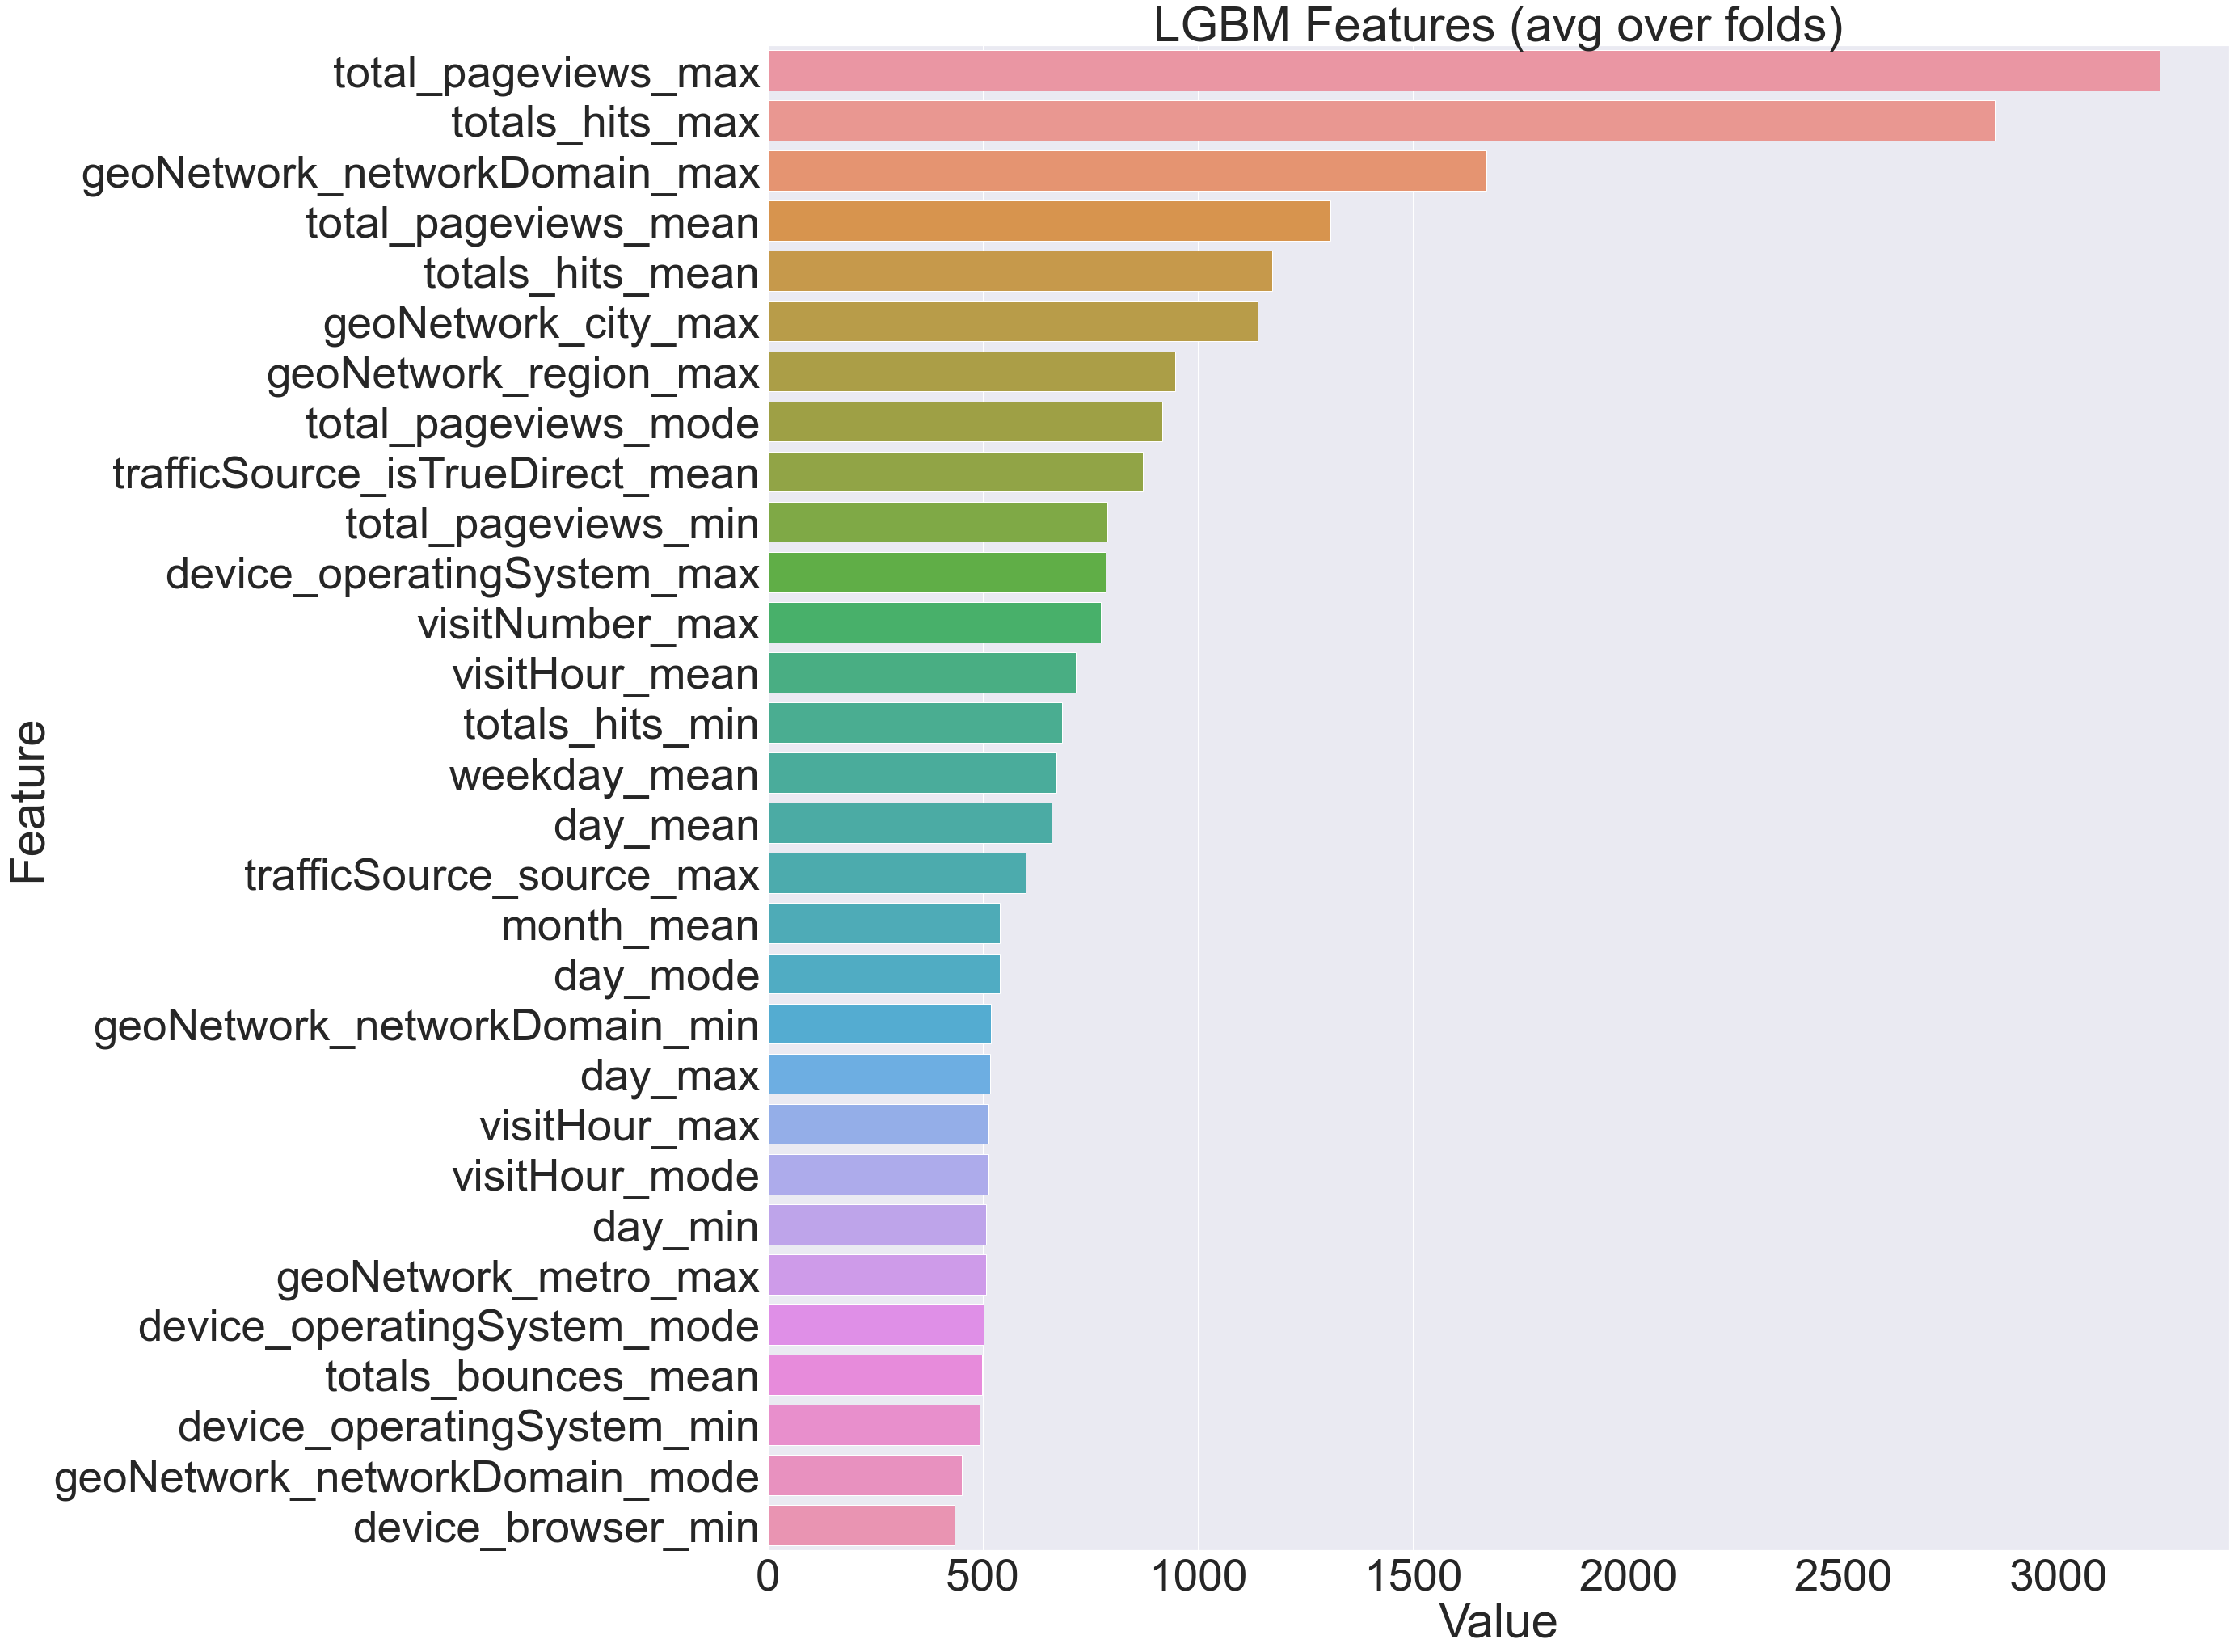

In [17]:
plotImp(lgbm, grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1) , num = 30, fig_size = (40, 30))

## XGBOOST Model

In [13]:
GridParams =  {
    'learning_rate': [0.0001,0.001,0.01,0.1,1],   #Learning rate
    'n_estimators': [30,40,60,100,200,350,400],          #number of boosting iterations   
   
    'objective' : ['reg:squarederror'],          #Regression model to predict transaction amount
    'colsample_bytree' : [0.6, 0.8, 1],    #LightGBM will select 80% of features before training each tree, feature_fraction
    'subsample' : [0.7,0.8,0.9, 1],            #this will randomly select part of data without resampling, bagging_fraction
    'reg_alpha' : [0,0.5,0.8,1],                   #L1 regularization
    'reg_lambda' : [0,0.5,0.8,1]                #L2 regularization
    }

In [14]:
xgbt = XGBRegressor()

#### Hyper Parameter Tuning using Random Search

In [15]:
random_search = RandomizedSearchCV(xgbt, GridParams, scoring='neg_root_mean_squared_error',return_train_score=True,random_state=0)
%time random_search.fit(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1), grouped_train_df['log_Revenue'])


Wall time: 1h 50min 12s


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, gamma=None,
                                          gpu_id=None, importance_type='gain',
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=100, n_jobs...
                                          validate_parameters=None,
                                          verbosity=None),
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1],
        

#### Best Hyper parameters

In [16]:
results=pd.DataFrame(random_search.cv_results_)
results.sort_values(by='rank_test_score',inplace=True)
results.params.values[0]

{'subsample': 0.8,
 'reg_lambda': 0.5,
 'reg_alpha': 1,
 'objective': 'reg:squarederror',
 'n_estimators': 200,
 'learning_rate': 0.1,
 'colsample_bytree': 0.6}

In [10]:
xgbt = XGBRegressor(subsample= 0.8, reg_lambda =0.5, reg_alpha= 1 ,objective='reg:squarederror', n_estimators = 200,learning_rate= 0.1,colsample_bytree= 0.6)

xgbt.fit(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1), grouped_train_df['log_Revenue'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=1, reg_lambda=0.5, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

#### RMSE on Train Data

In [11]:
np.sqrt(np.sum(np.square(xgbt.predict(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1))-grouped_train_df['log_Revenue']))/len(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

1.2216523001581814

#### RMSE on Test Data

In [12]:
np.sqrt(np.sum(np.square(xgbt.predict(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1))-grouped_test_df['log_Revenue']))/len(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

1.300953824285732

## Gradient Boosting Decision Tree 

In [37]:
from sklearn.ensemble import GradientBoostingRegressor

In [16]:
GridParams =  {
    'learning_rate': [0.0001,0.001,0.01,0.1,1],   #Learning rate
    'n_estimators': [30,40,60,100,200,350,400],          #number of boosting iterations   
    'subsample' : [0.7,0.8,0.9, 1],            #this will randomly select part of data without resampling, bagging_fraction
    'min_samples_split' : [2,4,6],
    'min_samples_leaf':[1,2,3],
    'max_depth' : [3,5,8,10]
              #Minimum number of data points needed in a child (leaf) node.   
    }

In [17]:
gbdt = GradientBoostingRegressor()

#### Hyper Parameters Tuning using Random Search

In [20]:
random_search = RandomizedSearchCV(gbdt, GridParams, scoring='neg_root_mean_squared_error',return_train_score=True,random_state=0,n_jobs = -1)
%time random_search.fit(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1), grouped_train_df['log_Revenue'])


Wall time: 5h 48min 39s


RandomizedSearchCV(estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.0001, 0.001, 0.01,
                                                          0.1, 1],
                                        'max_depth': [3, 5, 8, 10],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [30, 40, 60, 100, 200,
                                                         350, 400],
                                        'subsample': [0.7, 0.8, 0.9, 1]},
                   random_state=0, return_train_score=True,
                   scoring='neg_root_mean_squared_error')

#### Best Hyper parameters

In [21]:
results=pd.DataFrame(random_search.cv_results_)
results.sort_values(by='rank_test_score',inplace=True)
results.params.values[0]

{'subsample': 0.7,
 'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 3,
 'max_depth': 5,
 'learning_rate': 0.1}

In [8]:
gbdt = GradientBoostingRegressor(subsample= 0.7,  n_estimators = 400,learning_rate= 0.1, min_samples_split = 2, min_samples_leaf= 3, max_depth = 5)

%time gbdt.fit(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1), grouped_train_df['log_Revenue'])

Wall time: 34min 4s


GradientBoostingRegressor(max_depth=5, min_samples_leaf=3, n_estimators=400,
                          subsample=0.7)

#### RMSE on Train Data

In [9]:
%time np.sqrt(np.sum(np.square(gbdt.predict(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1))-grouped_train_df['log_Revenue']))/len(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

Wall time: 8.56 s


1.195505263568269

#### RMSE on Test Data

In [10]:
%time np.sqrt(np.sum(np.square(gbdt.predict(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1))-grouped_test_df['log_Revenue']))/len(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

Wall time: 1.4 s


1.2897114981658226

## Random Forest

In [6]:
from sklearn.ensemble import RandomForestRegressor

In [17]:
GridParams =  {
    'n_estimators': [60,100,200,350,400,500], #number of boosting iterations   
    'max_depth': [None,5,10,20,30],# The maximum depth of the tree
    'min_samples_split' : [2,4,6,8], # The minimum number of samples required to split an internal node
    'min_samples_leaf':[1,2,3], #The minimum number of samples required to be at a leaf node

              #Minimum number of data points needed in a child (leaf) node.   
    }

In [18]:
rfr = RandomForestRegressor()

In [24]:
random_search = RandomizedSearchCV(rfr, GridParams, scoring='neg_root_mean_squared_error',return_train_score=True,random_state=0,n_jobs = -1)
%time random_search.fit(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1), grouped_train_df['log_Revenue'])

Wall time: 4h 15min 45s


RandomizedSearchCV(estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [None, 5, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 4, 6, 8],
                                        'n_estimators': [60, 100, 200, 350, 400,
                                                         500]},
                   random_state=0, return_train_score=True,
                   scoring='neg_root_mean_squared_error')

In [25]:
results=pd.DataFrame(random_search.cv_results_)
results.sort_values(by='rank_test_score',inplace=True)
results.params.values[0]

{'n_estimators': 100,
 'min_samples_split': 6,
 'min_samples_leaf': 2,
 'max_depth': None}

In [7]:
rfr = RandomForestRegressor( n_estimators = 100, min_samples_split = 6, min_samples_leaf = 2, max_depth = None, n_jobs = -1)

%time rfr.fit(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1), grouped_train_df['log_Revenue'])

Wall time: 4min 41s


RandomForestRegressor(min_samples_leaf=2, min_samples_split=6, n_jobs=-1)

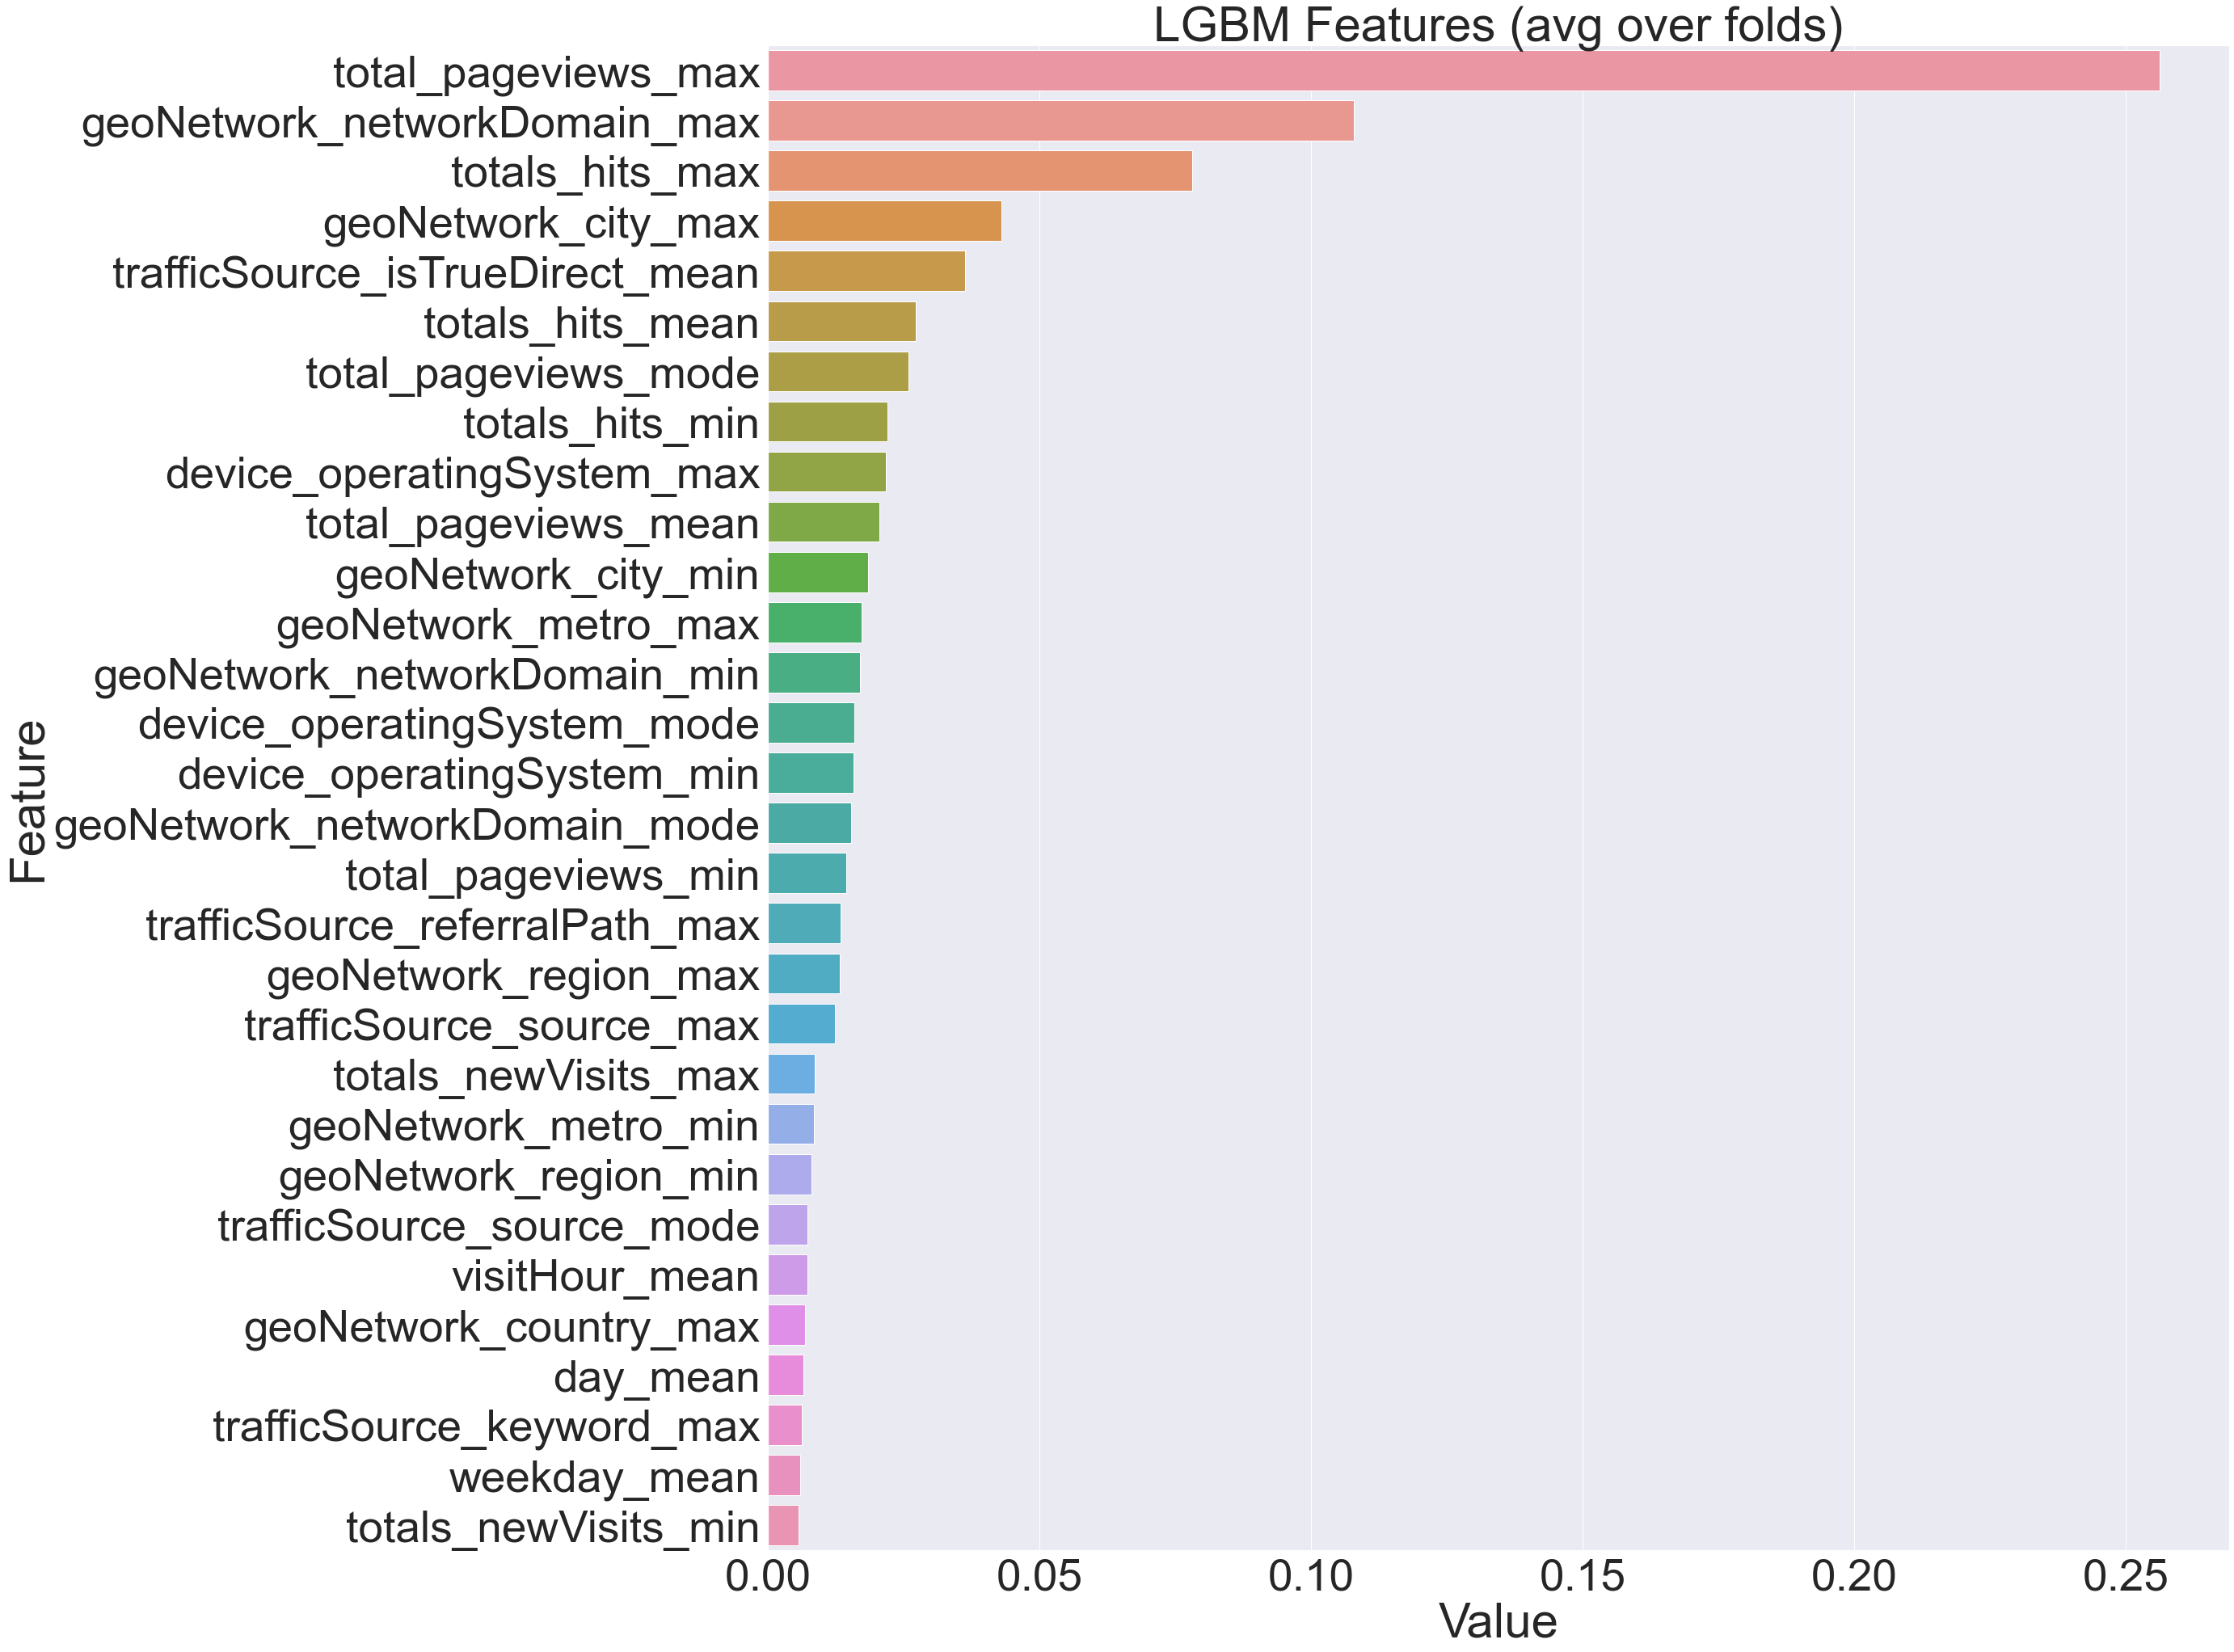

In [73]:
plotImp(rfr, grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1) , num = 30, fig_size = (40, 30))

In [74]:
%time np.sqrt(np.sum(np.square(rfr.predict(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1))-grouped_train_df['log_Revenue']))/len(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

Wall time: 2.21 s


0.5075197126060914

In [76]:
pickle.dump(rfr, open("saved_random_forest", 'wb'))

In [31]:
%time np.sqrt(np.sum(np.square(rfr.predict(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1))-grouped_test_df['log_Revenue']))/len(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

Wall time: 1.11 s


0.9442356420140502

## Stacked Model

reference - http://rasbt.github.io/mlxtend/user_guide/regressor/StackingRegressor/

### Stacked model made up of LGBMRegressor, GradientBoostingRegressor, XGBRegressor and RandomForestRegressor, and the meta regressor is LGBMRegressor

In [35]:
from mlxtend.regressor import StackingRegressor

In [38]:
lgbm = lgb.LGBMRegressor(subsample= 0.7, reg_lambda =1, reg_alpha= 0.5 ,objective='regression', num_leaves=100, n_estimators = 350, min_child_samples= 1,metric='rmse',learning_rate= 0.1,colsample_bytree= 0.8,boosting_type='gbdt')
gbdt = GradientBoostingRegressor(subsample= 0.7,  n_estimators = 400,learning_rate= 0.1, min_samples_split = 2, min_samples_leaf= 3, max_depth = 5)
xgbt = XGBRegressor(subsample= 0.8, reg_lambda =0.5, reg_alpha= 1 ,objective='reg:squarederror', n_estimators = 200,learning_rate= 0.1,colsample_bytree= 0.6)
rfr = RandomForestRegressor( n_estimators = 100, min_samples_split = 6, min_samples_leaf = 2, max_depth = None, n_jobs = -1)
meta_lgbm = lgb.LGBMRegressor()

In [39]:
regressors = [lgbm, gbdt, xgbt, rfr]
stregr = StackingRegressor(regressors=regressors, meta_regressor=meta_lgbm )#, use_features_in_secondary=True

In [40]:
%time stregr.fit(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1), grouped_train_df['log_Revenue'])

Wall time: 40min 58s


StackingRegressor(meta_regressor=LGBMRegressor(),
                  regressors=[LGBMRegressor(colsample_bytree=0.8, metric='rmse',
                                            min_child_samples=1,
                                            n_estimators=350, num_leaves=100,
                                            objective='regression',
                                            reg_alpha=0.5, reg_lambda=1,
                                            subsample=0.7),
                              GradientBoostingRegressor(max_depth=5,
                                                        min_samples_leaf=3,
                                                        n_estimators=400,
                                                        subsample=0.7),
                              XGBRegressor(base_score=None, boost...
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
      

In [41]:
%time np.sqrt(np.sum(np.square(stregr.predict(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1))-grouped_train_df['log_Revenue']))/len(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

Wall time: 15.8 s


0.13068395275143543

In [42]:
%time np.sqrt(np.sum(np.square(stregr.predict(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1))-grouped_test_df['log_Revenue']))/len(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

Wall time: 3.02 s


0.989914847990373

### Stacked model made up of LGBMRegressor, GradientBoostingRegressor, XGBRegressor, and the meta regressor is LGBMRegressor

In [ ]:
lgbm = lgb.LGBMRegressor(subsample= 0.7, reg_lambda =1, reg_alpha= 0.5 ,objective='regression', num_leaves=100, n_estimators = 350, min_child_samples= 1,metric='rmse',learning_rate= 0.1,colsample_bytree= 0.8,boosting_type='gbdt')
gbdt = GradientBoostingRegressor(subsample= 0.7,  n_estimators = 400,learning_rate= 0.1, min_samples_split = 2, min_samples_leaf= 3, max_depth = 5)
xgbt = XGBRegressor(subsample= 0.8, reg_lambda =0.5, reg_alpha= 1 ,objective='reg:squarederror', n_estimators = 200,learning_rate= 0.1,colsample_bytree= 0.6)
meta_lgbm = lgb.LGBMRegressor()

In [ ]:
regressors = [lgbm, gbdt, xgbt]
stregr = StackingRegressor(regressors=regressors, meta_regressor=meta_lgbm )#, use_features_in_secondary=True

In [15]:
%time stregr.fit(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1), grouped_train_df['log_Revenue'])

Wall time: 38min 14s


StackingRegressor(meta_regressor=LGBMRegressor(),
                  regressors=[LGBMRegressor(colsample_bytree=0.8, metric='rmse',
                                            min_child_samples=1,
                                            n_estimators=350, num_leaves=100,
                                            objective='regression',
                                            reg_alpha=0.5, reg_lambda=1,
                                            subsample=0.7),
                              GradientBoostingRegressor(max_depth=5,
                                                        min_samples_leaf=3,
                                                        n_estimators=400,
                                                        subsample=0.7),
                              XGBRegressor(base_score=None, boost...
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
            

#### RMSE on Train Data

In [16]:
%time np.sqrt(np.sum(np.square(stregr.predict(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1))-grouped_train_df['log_Revenue']))/len(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

Wall time: 14.1 s


0.3645889179670191

#### RMSE on Test Data

In [17]:
%time np.sqrt(np.sum(np.square(stregr.predict(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1))-grouped_test_df['log_Revenue']))/len(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

Wall time: 2.55 s


0.968438888046577

#### Stacked Model, where the original features where also fed to the Meta Regressor

In [18]:
regressors = [lgbm, gbdt, xgbt]
stregr = StackingRegressor(regressors=regressors, meta_regressor=meta_lgbm , use_features_in_secondary=True)

In [19]:
%time stregr.fit(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1), grouped_train_df['log_Revenue'])

Wall time: 39min 44s


StackingRegressor(meta_regressor=LGBMRegressor(),
                  regressors=[LGBMRegressor(colsample_bytree=0.8, metric='rmse',
                                            min_child_samples=1,
                                            n_estimators=350, num_leaves=100,
                                            objective='regression',
                                            reg_alpha=0.5, reg_lambda=1,
                                            subsample=0.7),
                              GradientBoostingRegressor(max_depth=5,
                                                        min_samples_leaf=3,
                                                        n_estimators=400,
                                                        subsample=0.7),
                              XGBRegressor(base_score=None, boost...
                                           interaction_constraints=None,
                                           learning_rate=0.1,
                              

In [20]:
%time np.sqrt(np.sum(np.square(stregr.predict(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1))-grouped_train_df['log_Revenue']))/len(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

Wall time: 15 s


0.24165030535547283

In [21]:
%time np.sqrt(np.sum(np.square(stregr.predict(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1))-grouped_test_df['log_Revenue']))/len(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

Wall time: 2.63 s


0.9713845493286166

## Linear Models

In [8]:
ss = StandardScaler()
x_train_s = ss.fit_transform(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1))

In [9]:
x_test_s = ss.transform(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1))

## Ridge

In [10]:
ridge = Ridge()

#### Hyper Parameter Tuning using Random Search 

In [18]:
params = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100],'fit_intercept':[True,False]}

random_search = RandomizedSearchCV(ridge, params, scoring='neg_root_mean_squared_error',return_train_score=True,random_state=0)
%time random_search.fit(x_train_s,grouped_train_df['log_Revenue'])

Wall time: 35.1 s


RandomizedSearchCV(estimator=Ridge(alpha=10),
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'fit_intercept': [True, False]},
                   random_state=0, return_train_score=True,
                   scoring='neg_root_mean_squared_error')

#### Best Hyper parameters

In [19]:
results=pd.DataFrame(random_search.cv_results_)
results.sort_values(by='rank_test_score',inplace=True)
results.params.values[0]

{'fit_intercept': True, 'alpha': 10}

In [20]:
ridge = Ridge(fit_intercept = True, alpha = 10)
ridge.fit(x_train_s, grouped_train_df['log_Revenue'])

Ridge(alpha=10)

#### RMSE on Train Data

In [34]:
%time np.sqrt(np.sum(np.square(ridge.predict(x_train_s)-grouped_train_df['log_Revenue']))/len(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

Wall time: 285 ms


1.976064640946649

#### RMSE on Test Data

In [36]:
%time np.sqrt(np.sum(np.square(ridge.predict(x_test_s)-grouped_test_df['log_Revenue']))/len(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

Wall time: 53.3 ms


1.9678479541625569

## Lasso

In [22]:
lasso = Lasso()

#### Hyper parameter tuning using Random Search

In [23]:
params = {'alpha':[0.0001,0.001,0.01,0.1,1,10,100],'fit_intercept':[True,False]}

random_search = RandomizedSearchCV(lasso, params, scoring='neg_root_mean_squared_error',return_train_score=True,random_state=0)
%time random_search.fit(x_train_s,grouped_train_df['log_Revenue'])

C:\Users\dhira\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 177549.70757695497, tolerance: 244.10826525690538
  positive)
C:\Users\dhira\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 193784.04311093502, tolerance: 245.03637596050027
  positive)
C:\Users\dhira\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 143817.45668434934, tolerance: 244.48098633998765
  positive)
C:\Users\dhira\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:532: ConvergenceWarning: Objective di

Wall time: 14min 41s


RandomizedSearchCV(estimator=Lasso(),
                   param_distributions={'alpha': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'fit_intercept': [True, False]},
                   random_state=0, return_train_score=True,
                   scoring='neg_root_mean_squared_error')

#### Best Hyperparameters

In [24]:
results=pd.DataFrame(random_search.cv_results_)
results.sort_values(by='rank_test_score',inplace=True)
results.params.values[0]

{'fit_intercept': True, 'alpha': 0.001}

In [29]:
lasso = Lasso(alpha = 0.001, fit_intercept = True )

In [31]:
%time lasso.fit(x_train_s, grouped_train_df['log_Revenue'])

Wall time: 51.2 s


Lasso(alpha=0.001)

#### RMSE on Train Data

In [26]:
%time np.sqrt(np.sum(np.square(lasso.predict(x_train_s)-grouped_train_df['log_Revenue']))/len(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

Wall time: 316 ms


1.9767603053265903

#### RMSE on Test Data

In [39]:
%time np.sqrt(np.sum(np.square(lasso.predict(x_test_s)-grouped_test_df['log_Revenue']))/len(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

Wall time: 62.5 ms


1.9682726497358354

## K Nearest Neighbours

In [12]:
from sklearn import neighbors

#### Considering 3 Nearest Neighbours

In [14]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 3, weights = "distance",algorithm = "kd_tree")

In [15]:
%time knn.fit(x_train_s, grouped_train_df['log_Revenue'])

Wall time: 39min 58s


KNeighborsRegressor(algorithm='kd_tree', n_neighbors=3, weights='distance')

#### RMSE on Trained Data

In [16]:
%time np.sqrt(np.sum(np.square(knn.predict(x_train_s)-grouped_train_df['log_Revenue']))/len(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

Wall time: 6h 47s


0.0

#### RMSE On Test Data

In [17]:
%time np.sqrt(np.sum(np.square(knn.predict(x_test_s)-grouped_test_df['log_Revenue']))/len(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

Wall time: 1h 24min 28s


1.8077338805743506

#### Considering 5 Nearest Neighbour

In [12]:
knn = neighbors.KNeighborsRegressor(n_neighbors = 5, weights = "distance")

In [13]:
knn.fit(x_train_s, grouped_train_df['log_Revenue'])

KNeighborsRegressor(weights='distance')

#### RMSE on Train Data

In [15]:
np.sqrt(np.sum(np.square(knn.predict(x_train_s)-grouped_train_df['log_Revenue']))/len(grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

0.0

#### RMSE on Test Data

In [16]:
np.sqrt(np.sum(np.square(knn.predict(x_test_s)-grouped_test_df['log_Revenue']))/len(grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1)))

1.734853621119538

## Deep Learning Model

In [6]:
from keras.layers import Dense, Flatten, Input, Dropout, concatenate, BatchNormalization
from tensorflow.keras.models import Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
import tensorflow as tf
import os
import datetime

In [7]:
np_train = np.array( grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1) ,dtype=float)
np_train.shape

(610377, 80)

In [8]:
%load_ext tensorboard
# Clear any logs from previous runs
!rm -rf ./logs/ 

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [9]:
np_test = np.array( grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1) )
np_test.shape

(108324, 80)

In [106]:
np_train = np_train.reshape([610377,80,1])
np_test = np_test.reshape([108324,80,1])

## Convolutional Neural Network

In [55]:
input_layer = Input(shape=(80,1))

conv11 = Conv1D(filters=8, kernel_size=2, padding='same', activation='relu')(input_layer)
conv13 = Conv1D(filters=16, kernel_size=4, padding='same', activation='relu')(input_layer)
conv15 = Conv1D(filters=32, kernel_size=8, padding='same', activation='relu')(input_layer)
concat_layer1 = concatenate([conv11, conv13, conv15], axis=-1)
pool_layer1=MaxPooling1D(3, strides=1, padding='same')(concat_layer1)

conv21 = Conv1D(filters=8, kernel_size=2, padding='same', activation='relu')(pool_layer1)
conv23 = Conv1D(filters=16, kernel_size=4, padding='same', activation='relu')(pool_layer1)
conv25 = Conv1D(filters=32, kernel_size=8, padding='same', activation='relu')(pool_layer1)
concat_layer2 = concatenate([conv21, conv23, conv25], axis=-1)

pool_layer1=MaxPooling1D(3, strides=1, padding='same')(concat_layer2)

conv3=Conv1D(filters=64, kernel_size=8, padding='same', activation='relu')(pool_layer1)

flat_layer = Flatten()(conv3)

batchnorm = BatchNormalization()(flat_layer)
dropped_out = Dropout(0.4)(batchnorm)

dense_layer0 = Dense(64, activation='relu')(dropped_out)

dense_layer1 = Dense(32, activation='relu')(dense_layer0)

dense_layer2 = Dense(16, activation='relu')(dense_layer1)

dense_layer3 = Dense(8, activation='relu')(dense_layer2)

dense_layer4 = Dense(4, activation='relu')(dense_layer3)

dense_layer5 = Dense(4, activation='relu')(dense_layer4)

dense_layer_output = Dense(1, activation=tf.keras.activations.linear)(dense_layer5)

In [56]:
model1 = Model(inputs=input_layer,outputs=dense_layer_output)
print(model1.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 80, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_28 (Conv1D)              (None, 80, 8)        24          input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 80, 16)       80          input_5[0][0]                    
__________________________________________________________________________________________________
conv1d_30 (Conv1D)              (None, 80, 32)       288         input_5[0][0]                    
____________________________________________________________________________________________

In [57]:
log_dir1 = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir1,histogram_freq=1,write_graph=True)

In [58]:
model1.compile(loss='mean_squared_error',optimizer='adam',metrics=tf.keras.metrics.RootMeanSquaredError())

In [21]:
model1.fit(np_train,grouped_train_df['log_Revenue'], validation_data=(np_test,grouped_test_df['log_Revenue']), epochs=20, verbose=2, callbacks=[tensorboard_callback],batch_size = 256)

Epoch 1/5
2385/2385 - 345s - loss: 4.5875 - root_mean_squared_error: 2.1418 - val_loss: 4.4752 - val_root_mean_squared_error: 2.1155
Epoch 2/5
2385/2385 - 299s - loss: 4.4400 - root_mean_squared_error: 2.1071 - val_loss: 5.6911 - val_root_mean_squared_error: 2.3856
Epoch 3/5
2385/2385 - 299s - loss: 4.3973 - root_mean_squared_error: 2.0970 - val_loss: 5.0341 - val_root_mean_squared_error: 2.2437
Epoch 4/5
2385/2385 - 299s - loss: 4.3601 - root_mean_squared_error: 2.0881 - val_loss: 1203810.3750 - val_root_mean_squared_error: 1097.1830
Epoch 5/5
2385/2385 - 299s - loss: 4.3380 - root_mean_squared_error: 2.0828 - val_loss: 5.2958 - val_root_mean_squared_error: 2.3013


In [60]:
%tensorboard --logdir=logs/

## Multi Layer Perceptron

In [4]:
np_train = np.array( grouped_train_df.drop(['log_Revenue','fullVisitorId'], axis=1) ,dtype=float)
np_test = np.array( grouped_test_df.drop(['log_Revenue','fullVisitorId'], axis=1) )

In [21]:
input_layer = Input(shape=(80))
#Dense hidden layer
layer1 = Dense(128,activation='relu')(input_layer)
layer2 = Dense(64,activation='relu')(layer1)
layer3 = Dense(32,activation='relu')(layer2)
layer4 = Dense(16,activation='relu')(layer3)
layer5 = Dense(8,activation='relu')(layer4)
layer6 = Dense(1,activation='sigmoid')(layer5)

concat_layer = concatenate([input_layer, layer6], axis=-1)

layer7 = Dense(64,activation='relu')(concat_layer)
#
batchnorm = BatchNormalization()(layer7)
dropped_out = Dropout(0.3)(batchnorm)
#
layer8 = Dense(32,activation='relu')(dropped_out)
layer9 = Dense(16,activation='relu')(layer8)
layer10 = Dense(8,activation='relu')(layer9)
layer11 = Dense(4,activation='relu')(layer10)
layer12 = Dense(4,activation='relu')(layer11)

dense_layer_output = Dense(1,activation='linear')(layer12)


In [22]:
model2 = Model(inputs=input_layer,outputs=dense_layer_output)
print(model2.summary())

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 128)          10368       input_3[0][0]                    
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 64)           8256        dense_25[0][0]                   
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 32)           2080        dense_26[0][0]                   
____________________________________________________________________________________________

In [23]:
log_dir1 = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir1,histogram_freq=1,write_graph=True)

In [24]:
model2.compile(loss='mean_squared_error',optimizer='adam',metrics=tf.keras.metrics.RootMeanSquaredError())

In [25]:
model2.fit(np_train,grouped_train_df['log_Revenue'], validation_data=(np_test,grouped_test_df['log_Revenue']), epochs=5, verbose=2,callbacks=[tensorboard_callback], batch_size = 256)

Epoch 1/5
2385/2385 - 25s - loss: 4.5332 - root_mean_squared_error: 2.1291 - val_loss: 4.4640 - val_root_mean_squared_error: 2.1128
Epoch 2/5
2385/2385 - 23s - loss: 4.4761 - root_mean_squared_error: 2.1157 - val_loss: 4.6319 - val_root_mean_squared_error: 2.1522
Epoch 3/5
2385/2385 - 24s - loss: 4.4549 - root_mean_squared_error: 2.1107 - val_loss: 5.2271 - val_root_mean_squared_error: 2.2863
Epoch 4/5
2385/2385 - 23s - loss: 4.4278 - root_mean_squared_error: 2.1042 - val_loss: 4.5641 - val_root_mean_squared_error: 2.1364
Epoch 5/5
2385/2385 - 23s - loss: 4.4221 - root_mean_squared_error: 2.1029 - val_loss: 4.5324 - val_root_mean_squared_error: 2.1289


# Overall Performance 

In [2]:
model_results = pd.DataFrame([["RandomForestRegressor", round(0.5061828658737597,3), round(0.9642356420140502,3)],["LGBMRegressor", round(0.5979622712262007,3), round(0.9547818183371161,3)], ["XGBRegressor", round(1.2216523001581814,3), round(1.300953824285732,3)], ['GradientBoostingRegressor',round(1.195505263568269,3), round(1.2897114981658226, 3) ],['StackingRegressor', round(0.3645889179670191,3), round(0.968438888046577,3)],['StackingRegressor,features fed to Meta Regressor',round( 0.24165030535547283,3),round(0.9713845493286166,3)],['Ridge',round(1.976064640946649,3), round(1.9678479541625569,3)],["Lasso",round(1.9767603053265903,3), round(1.9682726497358354,3)],["NeighborsRegressor, K=3",0.0,round(1.8077338805743506,3)],["NeighborsRegressor, K=5",0.0,round(1.734853621119538,3)],['Convolutional Neural Network',round(2.0820,3),round(2.6684,3)],['Multi Layered Perceptron',round(2.1029,3),round(2.1289,3)]])

In [3]:
model_results.columns  = ["Model Name", "RMSE on Train Data", "RMSE on Test Data"]

model_results.sort_values(by='RMSE on Test Data',inplace=True)
model_results

,Model Name,RMSE on Train Data,RMSE on Test Data
1,LGBMRegressor,0.598,0.955
0,RandomForestRegressor,0.506,0.964
4,StackingRegressor,0.365,0.968
5,"StackingRegressor,features fed to Meta Regressor",0.242,0.971
3,GradientBoostingRegressor,1.196,1.290
2,XGBRegressor,1.222,1.301
9,"NeighborsRegressor, K=5",0.000,1.735
8,"NeighborsRegressor, K=3",0.000,1.808
6,Ridge,1.976,1.968
7,Lasso,1.977,1.968


# Finally Choosen Model - LGBM

## Video Demo -- https://www.youtube.com/watch?v=xUwqoiq6sjk

# Function which takes the user data to Predict the revenue

In [9]:
def predict(df):
    
    allowed_columns = ['channelGrouping', 'date', 'fullVisitorId', 'visitNumber', 'visitStartTime', 'device.browser',
                       'device.operatingSystem','device.isMobile', 'device.deviceCategory', 'geoNetwork.continent',
                       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region', 'geoNetwork.metro', 
                       'geoNetwork.city', 'geoNetwork.networkDomain', 'totals.hits', 'totals.pageviews', 
                       'totals.bounces', 'totals.newVisits', 'trafficSource.campaign',
                       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
                       'trafficSource.isTrueDirect', 'trafficSource.referralPath']
     
    
    for column in df.columns:
        if column not in allowed_columns:
            df = df.drop(column, axis=1)
            
    #print(df.columns)
    df['date'] = pd.to_datetime(df["date"], infer_datetime_format=True, format="%Y%m%d")
    df['weekday'] = df.date.dt.weekday
    df['day'] = df.date.dt.day
    df['month'] = df.date.dt.month
    df['year' ] = df.date.dt.year
    
    def process_time(posix_time):
        return datetime.utcfromtimestamp(posix_time).strftime('%Y-%m-%d %H:%M:%S')
    def process_hour(time):
        return str(time)[-8:-6]

    df['visitStartTime'] = df['visitStartTime'].apply(process_time)
    df['visitHour'] = df['visitStartTime'].apply(process_hour)
    categorical_columns=['channelGrouping','device.browser','device.operatingSystem','device.isMobile','device.deviceCategory','geoNetwork.continent','geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region','geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain','totals.bounces','totals.newVisits','trafficSource.campaign','trafficSource.source','trafficSource.medium', 'trafficSource.keyword','trafficSource.isTrueDirect','trafficSource.referralPath','weekday','day','month','year','visitHour']

    file = open("encoder.obj",'rb')
    encoder = pickle.load(file)
    file.close()

    df[categorical_columns] = encoder.transform( df[categorical_columns] )

    df['totals.pageviews'].fillna(2.0,inplace=True)
    #print(pd.DataFrame(df))
    

    grouped_df = df.groupby('fullVisitorId').agg({ 'totals.pageviews':[('total_pageviews_max',lambda x : x.dropna().max()),
                                                                   ('total_pageviews_min',lambda x : x.dropna().min()), 
                                                                   ('total_pageviews_mean',lambda x : x.dropna().mean()),
                                                                   ('total_pageviews_mode',lambda x : x.value_counts().index[0])],
                                           
                                     'channelGrouping': [('channelGrouping_max',lambda x : x.dropna().max()),
                                                         ('channelGrouping_min',lambda x : x.dropna().min()),
                                                         ('channelGrouping_mode',lambda x : x.value_counts().index[0])],
                                           
                                     'visitNumber': [('visitNumber_max',lambda x : x.dropna().max()),
                                                     ('visitNumber_mean',lambda x : x.dropna().mean()),
                                                     ('visitNumber_min',lambda x : x.dropna().min())],
                                           
                                     'device.browser':[('device_browser_max',lambda x : x.dropna().max()),
                                                       ('device_browser_min',lambda x : x.dropna().min()),
                                                       ('device_browser_mode',lambda x : x.value_counts().index[0])],
                                           
                                    'device.operatingSystem':[('device_operatingSystem_max',lambda x : x.dropna().max()),
                                                              ('device_operatingSystem_min',lambda x : x.dropna().min()),
                                                              ('device_operatingSystem_mode',lambda x : x.value_counts().index[0])],
                                   
                                     'device.isMobile':[('device_isMobile_max',lambda x : x.dropna().max()),
                                                        ('device_isMobile_min',lambda x : x.dropna().min())],
                                           
                                   'device.deviceCategory':[('device_deviceCategory_max',lambda x : x.dropna().max()),
                                                            ('device_deviceCategory_min',lambda x : x.dropna().min()),
                                                            ('device_deviceCategory_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'geoNetwork.continent':[('geoNetwork_continent_max',lambda x : x.dropna().max()),
                                                           ('geoNetwork_continent_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.subContinent':[('geoNetwork_subContinent_max',lambda x : x.dropna().max()),
                                                              ('geoNetwork_subContinent_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.country':[('geoNetwork_country_max',lambda x : x.dropna().max()),
                                                         ('geoNetwork_country_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.region':[('geoNetwork_region_max',lambda x : x.dropna().max()),
                                                        ('geoNetwork_region_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.metro':[('geoNetwork_metro_max',lambda x : x.dropna().max()),
                                                       ('geoNetwork_metro_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.city':[('geoNetwork_city_max',lambda x : x.dropna().max()),
                                                      ('geoNetwork_city_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.networkDomain':[('geoNetwork_networkDomain_max',lambda x : x.dropna().max()),
                                                               ('geoNetwork_networkDomain_min',lambda x : x.dropna().min()),
                                                               ('geoNetwork_networkDomain_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'totals.hits':[('totals_hits_max',lambda x : x.dropna().max()),
                                                  ('totals_hits_min',lambda x : x.dropna().min()),
                                                  ('totals_hits_mean',lambda x : x.dropna().mean())],
                                           
                                   'totals.bounces':[('totals_bounces_max',lambda x : x.dropna().max()),
                                                     ('totals_bounces_min',lambda x : x.dropna().min()),
                                                     ('totals_bounces_mean',lambda x : x.dropna().mean())],
                                           
                                   'totals.newVisits':[('totals_newVisits_max',lambda x : x.dropna().max()),
                                                       ('totals_newVisits_min',lambda x : x.dropna().min())],
                                           
                                   'trafficSource.campaign':[('trafficSource_campaign_max',lambda x : x.dropna().max()),
                                                             ('trafficSource_campaign_min',lambda x : x.dropna().min()),
                                                             ('trafficSource_campaign_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'trafficSource.source':[('trafficSource_source_max',lambda x : x.dropna().max()),
                                                           ('trafficSource_source_min',lambda x : x.dropna().min()),
                                                           ('trafficSource_source_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'trafficSource.medium':[('trafficSource_medium_max',lambda x : x.dropna().max()),
                                                           ('trafficSource_medium_min',lambda x : x.dropna().min()),
                                                           ('trafficSource_medium_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'trafficSource.keyword':[('trafficSource_keyword_max',lambda x : x.dropna().max()),
                                                            ('trafficSource_keyword_min',lambda x : x.dropna().min())],
                                           
                                   'trafficSource.isTrueDirect':[('trafficSource_isTrueDirect_max',lambda x : x.dropna().max()),
                                                                 ('trafficSource_isTrueDirect_min',lambda x : x.dropna().min()),
                                                                 ('trafficSource_isTrueDirect_mean',lambda x : x.dropna().mean())],
                                           
                                   'trafficSource.referralPath':[('trafficSource_referralPath_max',lambda x : x.dropna().max()),
                                                                 ('trafficSource_referralPath_min',lambda x : x.dropna().min()),
                                                                 ('trafficSource_referralPath_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'weekday':[('weekday_max',lambda x : x.dropna().max()),
                                              ('weekday_min',lambda x : x.dropna().min()),
                                              ('weekday_mean',lambda x : x.dropna().mean()),
                                              ('weekday_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'day':[('day_max',lambda x : x.dropna().max()),
                                          ('day_min',lambda x : x.dropna().min()),
                                          ('day_mean',lambda x : x.dropna().mean()),
                                          ('day_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'month':[('month_max',lambda x : x.dropna().max()),
                                            ('month_min',lambda x : x.dropna().min()),
                                            ('month_mean',lambda x : x.dropna().mean()),
                                            ('month_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'year':[('year_max',lambda x : x.dropna().max()),
                                           ('year_min',lambda x : x.dropna().min()),
                                           ('year_mode',lambda x : x.value_counts().index[0])], 
                                           
                                   'visitHour':[('visitHour_max',lambda x : x.dropna().max()),
                                                ('visitHour_mean',lambda x : x.dropna().mean()),
                                                ('visitHour_min',lambda x : x.dropna().min()),
                                                ('visitHour_mode',lambda x : x.value_counts().index[0])]     
                                    })
    grouped_df.columns = grouped_df.columns.droplevel()
    grouped_df = grouped_df.reset_index()

    loaded_model = pickle.load(open("saved_lgbm.sav", 'rb'))
    predicted_value = loaded_model.predict(grouped_df.drop(['fullVisitorId'], axis=1).values.reshape(1, -1))
    
    return round(predicted_value[0],3)
    

#### Creating some sample Data for the users

In [395]:
df[df['fullVisitorId'] == "7414379690027141187"].to_csv('user_1.csv')
df[df['fullVisitorId'] == "0824839726118485274"].to_csv('user_2.csv')
df[df['fullVisitorId'] == "3269834865385146569"].to_csv('user_3.csv') 
df[df['fullVisitorId'] == "9801276214964695322"].to_csv('user_4.csv')
df[df['fullVisitorId'] == "3608475193341679870"].to_csv('user_5.csv')

#### Prediction of User 1

In [32]:
 predict(pd.read_csv('user_1.csv'))

0.05

#### Prediction of User 2

In [429]:
 predict(pd.read_csv('user_2.csv'))

array([8.32978368])

# Function which takes a dataset to give the RMSE Score of the Model

In [25]:
def model_performance(df):
    
    allowed_columns = ['channelGrouping', 'date', 'fullVisitorId', 'visitNumber', 'visitStartTime', 'device.browser',
                       'device.operatingSystem','device.isMobile', 'device.deviceCategory', 'geoNetwork.continent',
                       'geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region', 'geoNetwork.metro', 
                       'geoNetwork.city', 'geoNetwork.networkDomain', 'totals.hits', 'totals.pageviews', 
                       'totals.bounces', 'totals.newVisits', 'trafficSource.campaign',
                       'trafficSource.source', 'trafficSource.medium', 'trafficSource.keyword',
                       'trafficSource.isTrueDirect', 'trafficSource.referralPath','totals.transactionRevenue']
     
    
    for column in df.columns:
        if column not in allowed_columns:
            df = df.drop(column, axis=1)
            
    #print(df.columns)
    df['date'] = pd.to_datetime(df["date"], infer_datetime_format=True, format="%Y%m%d")
    df['weekday'] = df.date.dt.weekday
    df['day'] = df.date.dt.day
    df['month'] = df.date.dt.month
    df['year' ] = df.date.dt.year
    
    def process_time(posix_time):
        return datetime.utcfromtimestamp(posix_time).strftime('%Y-%m-%d %H:%M:%S')
    def process_hour(time):
        return str(time)[-8:-6]

    df['visitStartTime'] = df['visitStartTime'].apply(process_time)
    df['visitHour'] = df['visitStartTime'].apply(process_hour)
    categorical_columns=['channelGrouping','device.browser','device.operatingSystem','device.isMobile','device.deviceCategory','geoNetwork.continent','geoNetwork.subContinent', 'geoNetwork.country', 'geoNetwork.region','geoNetwork.metro', 'geoNetwork.city', 'geoNetwork.networkDomain','totals.bounces','totals.newVisits','trafficSource.campaign','trafficSource.source','trafficSource.medium', 'trafficSource.keyword','trafficSource.isTrueDirect','trafficSource.referralPath','weekday','day','month','year','visitHour']

    file = open("encoder.obj",'rb')
    encoder = pickle.load(file)
    file.close()

    df[categorical_columns] = encoder.transform( df[categorical_columns] )

    df['totals.pageviews'].fillna(2.0,inplace=True)
    #print(pd.DataFrame(df))
    

    grouped_df = df.groupby('fullVisitorId').agg({ 'totals.pageviews':[('total_pageviews_max',lambda x : x.dropna().max()),
                                                                   ('total_pageviews_min',lambda x : x.dropna().min()), 
                                                                   ('total_pageviews_mean',lambda x : x.dropna().mean()),
                                                                   ('total_pageviews_mode',lambda x : x.value_counts().index[0])],
                                           
                                     'channelGrouping': [('channelGrouping_max',lambda x : x.dropna().max()),
                                                         ('channelGrouping_min',lambda x : x.dropna().min()),
                                                         ('channelGrouping_mode',lambda x : x.value_counts().index[0])],
                                           
                                     'visitNumber': [('visitNumber_max',lambda x : x.dropna().max()),
                                                     ('visitNumber_mean',lambda x : x.dropna().mean()),
                                                     ('visitNumber_min',lambda x : x.dropna().min())],
                                           
                                     'device.browser':[('device_browser_max',lambda x : x.dropna().max()),
                                                       ('device_browser_min',lambda x : x.dropna().min()),
                                                       ('device_browser_mode',lambda x : x.value_counts().index[0])],
                                           
                                    'device.operatingSystem':[('device_operatingSystem_max',lambda x : x.dropna().max()),
                                                              ('device_operatingSystem_min',lambda x : x.dropna().min()),
                                                              ('device_operatingSystem_mode',lambda x : x.value_counts().index[0])],
                                   
                                     'device.isMobile':[('device_isMobile_max',lambda x : x.dropna().max()),
                                                        ('device_isMobile_min',lambda x : x.dropna().min())],
                                           
                                   'device.deviceCategory':[('device_deviceCategory_max',lambda x : x.dropna().max()),
                                                            ('device_deviceCategory_min',lambda x : x.dropna().min()),
                                                            ('device_deviceCategory_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'geoNetwork.continent':[('geoNetwork_continent_max',lambda x : x.dropna().max()),
                                                           ('geoNetwork_continent_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.subContinent':[('geoNetwork_subContinent_max',lambda x : x.dropna().max()),
                                                              ('geoNetwork_subContinent_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.country':[('geoNetwork_country_max',lambda x : x.dropna().max()),
                                                         ('geoNetwork_country_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.region':[('geoNetwork_region_max',lambda x : x.dropna().max()),
                                                        ('geoNetwork_region_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.metro':[('geoNetwork_metro_max',lambda x : x.dropna().max()),
                                                       ('geoNetwork_metro_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.city':[('geoNetwork_city_max',lambda x : x.dropna().max()),
                                                      ('geoNetwork_city_min',lambda x : x.dropna().min())],
                                           
                                   'geoNetwork.networkDomain':[('geoNetwork_networkDomain_max',lambda x : x.dropna().max()),
                                                               ('geoNetwork_networkDomain_min',lambda x : x.dropna().min()),
                                                               ('geoNetwork_networkDomain_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'totals.hits':[('totals_hits_max',lambda x : x.dropna().max()),
                                                  ('totals_hits_min',lambda x : x.dropna().min()),
                                                  ('totals_hits_mean',lambda x : x.dropna().mean())],
                                           
                                   'totals.bounces':[('totals_bounces_max',lambda x : x.dropna().max()),
                                                     ('totals_bounces_min',lambda x : x.dropna().min()),
                                                     ('totals_bounces_mean',lambda x : x.dropna().mean())],
                                           
                                   'totals.newVisits':[('totals_newVisits_max',lambda x : x.dropna().max()),
                                                       ('totals_newVisits_min',lambda x : x.dropna().min())],
                                           
                                   'trafficSource.campaign':[('trafficSource_campaign_max',lambda x : x.dropna().max()),
                                                             ('trafficSource_campaign_min',lambda x : x.dropna().min()),
                                                             ('trafficSource_campaign_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'trafficSource.source':[('trafficSource_source_max',lambda x : x.dropna().max()),
                                                           ('trafficSource_source_min',lambda x : x.dropna().min()),
                                                           ('trafficSource_source_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'trafficSource.medium':[('trafficSource_medium_max',lambda x : x.dropna().max()),
                                                           ('trafficSource_medium_min',lambda x : x.dropna().min()),
                                                           ('trafficSource_medium_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'trafficSource.keyword':[('trafficSource_keyword_max',lambda x : x.dropna().max()),
                                                            ('trafficSource_keyword_min',lambda x : x.dropna().min())],
                                           
                                   'trafficSource.isTrueDirect':[('trafficSource_isTrueDirect_max',lambda x : x.dropna().max()),
                                                                 ('trafficSource_isTrueDirect_min',lambda x : x.dropna().min()),
                                                                 ('trafficSource_isTrueDirect_mean',lambda x : x.dropna().mean())],
                                           
                                   'trafficSource.referralPath':[('trafficSource_referralPath_max',lambda x : x.dropna().max()),
                                                                 ('trafficSource_referralPath_min',lambda x : x.dropna().min()),
                                                                 ('trafficSource_referralPath_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'weekday':[('weekday_max',lambda x : x.dropna().max()),
                                              ('weekday_min',lambda x : x.dropna().min()),
                                              ('weekday_mean',lambda x : x.dropna().mean()),
                                              ('weekday_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'day':[('day_max',lambda x : x.dropna().max()),
                                          ('day_min',lambda x : x.dropna().min()),
                                          ('day_mean',lambda x : x.dropna().mean()),
                                          ('day_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'month':[('month_max',lambda x : x.dropna().max()),
                                            ('month_min',lambda x : x.dropna().min()),
                                            ('month_mean',lambda x : x.dropna().mean()),
                                            ('month_mode',lambda x : x.value_counts().index[0])],
                                           
                                   'year':[('year_max',lambda x : x.dropna().max()),
                                           ('year_min',lambda x : x.dropna().min()),
                                           ('year_mode',lambda x : x.value_counts().index[0])], 
                                           
                                   'visitHour':[('visitHour_max',lambda x : x.dropna().max()),
                                                ('visitHour_mean',lambda x : x.dropna().mean()),
                                                ('visitHour_min',lambda x : x.dropna().min()),
                                                ('visitHour_mode',lambda x : x.value_counts().index[0])],
                                                  
                                   'totals.transactionRevenue':[('revenue_sum',lambda x : x.dropna().sum())]

                                    })
    grouped_df.columns = grouped_df.columns.droplevel()
    grouped_df = grouped_df.reset_index()
    
    grouped_df['log_Revenue'] = np.log1p(grouped_df['revenue_sum'])
    grouped_df.drop('revenue_sum', axis=1, inplace = True)


    loaded_model = pickle.load(open("saved_lgbm.sav", 'rb'))
    
    
    return np.sqrt(np.sum(np.square(loaded_model.predict(grouped_df.drop(['log_Revenue','fullVisitorId'], axis=1))-grouped_df['log_Revenue']))/len(grouped_df.drop(['log_Revenue','fullVisitorId'], axis=1)))
    

#### Model performance on first 500 Data points
* I have avoided more number of Data Points considering the Time it may take

In [31]:
model_performance(df.iloc[:500])

0.018466058928358547

In [33]:
df.iloc[:500].to_csv("Sample_Data.csv")

## Density plot of Error on Test Data

In [91]:
import matplotlib.pyplot as plt

In [60]:
import seaborn as sns
for i in grouped_test_df.values:
    y = lgbm.predict(i[1:-1].reshape(1,-1))[0] # slicing to exclude the visitor id and log_Revenue
    l.append(y - i[-1])

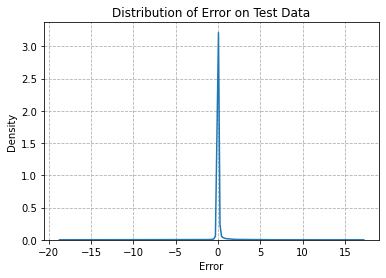

In [95]:
sns.kdeplot(l)
plt.xlabel('Error')
plt.grid(ls='--')
plt.title("Distribution of Error on Test Data")
plt.savefig('error_plot',dpi=800)
plt.show()

## Prediction on few Data Points

In [17]:
visitors = ["0001266240591974276", "4388991535775331190", "0032183854661944832", "0856720581469908496","438871929726168616", "468883568673338982","17811155224787359", "4247330352176377298","9162975122530103860","4389189443640627686"]
final = []
for i in visitors:
    nth = []
    nth.append(i)
    nth.append(grouped_test_df[grouped_test_df['fullVisitorId']==i].values[0][-1])
    nth.append(lgbm.predict(grouped_test_df[grouped_test_df['fullVisitorId']==i].values[0][1:-1].reshape(1, -1))[0])
    final.append(nth)

In [18]:
final = pd.DataFrame(final)
final.columns = ['fullVisitorId', 'predicted_log_revenue','actual_log_revenue']
final

,fullVisitorId,predicted_log_revenue,actual_log_revenue
0,0001266240591974276,17.909688,16.639429
1,4388991535775331190,0.000000,0.005476
2,0032183854661944832,18.985426,16.976678
3,0856720581469908496,18.387848,20.767778
4,438871929726168616,0.000000,0.435912
5,468883568673338982,18.034724,19.099061
6,17811155224787359,18.171963,19.212752
7,4247330352176377298,17.461743,19.930387
8,9162975122530103860,0.000000,0.003051
9,4389189443640627686,0.000000,0.000860
